# target encoder & ohe & just auoint

In [1]:
%load_ext autoreload
%autoreload 2

import os
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append(os.path.abspath('..'))
# ---------------------------------
from time import sleep
import numpy as np
import pandas as pd
import scipy
import tqdm
import tensorflow as tf
from tensorflow.keras.layers import Activation
import matplotlib.pyplot as plt

from category_encoders import TargetEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression, SGDRegressor
from sklearn.metrics import roc_auc_score

from hyperopt import hp
# ---------------------------------
from tools import CV, Tuning, CVGetScore, IdxValEncoder, auto_int, CyclicLR, MaxLrFinder
# ---------------------------------
from tools import focal_loss, gelu, mish
from tensorflow.keras.utils import get_custom_objects

get_custom_objects().update({'focal_loss': focal_loss()})
get_custom_objects().update({'mish': mish})
get_custom_objects().update({'gelu': gelu})

In [2]:
train_df = pd.read_csv('../data/train.csv', index_col='id')
test_df = pd.read_csv('../data/test.csv', index_col='id')

# ord_5
for i in range(2):
    train_df[f'ord_5_{i}'] = train_df['ord_5'].str[i]
    test_df[f'ord_5_{i}'] = test_df['ord_5'].str[i]

# null
train_df['null'] = train_df.isna().sum(axis=1)
test_df['null'] = test_df.isna().sum(axis=1)

for col in test_df.columns:
    train_df[col].fillna('isnull', inplace=True)
    test_df[col].fillna('isnull', inplace=True)

# target
target = train_df['target']
y_train = target.values

# drop
train_df.drop(['target', 'ord_5'], axis=1, inplace=True)
test_df.drop(['ord_5'], axis=1, inplace=True)

In [3]:
feature_col = train_df.columns

bin_col = ['null']

class_col = ['bin_0', 'bin_1', 'bin_2', 'bin_3', 'bin_4',
             'nom_0', 'nom_1', 'nom_2', 'nom_3', 'nom_4',
             'nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9',
             'ord_0', 'ord_1', 'ord_2', 'ord_3', 'ord_4',
             'day', 'month', 'ord_5_0', 'ord_5_1']

In [4]:
# for col in bin_col:
#     map_dict = dict(zip(train_df[col].unique(), [0., 1.]))
#     train_df[col] = train_df[col].map(map_dict)
#     test_df[col] = test_df[col].map(map_dict)

In [5]:
ecd = IdxValEncoder(feature_col, bin_col=bin_col, class_col=class_col)
ecd.fit(train_df, verbose=1)

600000it [00:10, 56821.20it/s]


In [6]:
ecd.fit(test_df, verbose=1)

400000it [00:07, 56071.72it/s]


In [7]:
idx, val = ecd.transform(train_df, verbose=1)
idx_test, val_test = ecd.transform(test_df, verbose=1)

600000it [00:12, 47162.54it/s]
400000it [00:08, 47636.93it/s]


# Search Max LR

In [8]:
%%time
%matplotlib inline

batch_size = 8192
epochs = 5
nflold = 5

model_param = {'vocabulary_size':ecd.get_vocabulary(), 
               'feature_number': len(feature_col),
               'activation': 'sigmoid',
               'metrics': ['AUC'],
               'optimizer': 'Adam',
               'loss': 'binary_crossentropy', 
               'use_linear': False, 'use_deep': False}

mf = MaxLrFinder(1e-5, 1e-1, epochs=epochs, batch_size=batch_size, sample_length=train_df.shape[0]*((nflold-1)/nflold))
fit_param = {'batch_size': batch_size, 'epochs':epochs, 'verbose': 1, 'callbacks':[mf]}

model = auto_int(**model_param)

cv = CV(model, nflold)

score = cv.fit(x=[idx, val],
               y=y_train, 
               metrics_func=roc_auc_score,
               split_method=StratifiedKFold,
               fit_params=fit_param,
               eval_param={'batch_size':batch_size},
               use_proba=False, 
               verbose=True,
               fit_use_valid=True)

tf.keras.backend.clear_session()

Train on 480000 samples, validate on 120000 samples
Epoch 1/5
480000/480000 [==============================] - 29s 60us/sample - loss: 0.6955 - AUC: 0.4778 - val_loss: 0.6932 - val_AUC: 0.4874
Epoch 2/5
480000/480000 [==============================] - 26s 55us/sample - loss: 0.6830 - AUC: 0.4902 - val_loss: 0.6521 - val_AUC: 0.4815
Epoch 3/5
480000/480000 [==============================] - 27s 56us/sample - loss: 0.5154 - AUC: 0.5392 - val_loss: 0.4469 - val_AUC: 0.7629
Epoch 4/5
480000/480000 [==============================] - 26s 55us/sample - loss: 0.4093 - AUC: 0.7718 - val_loss: 0.4002 - val_AUC: 0.7817
Epoch 5/5
480000/480000 [==============================] - 27s 55us/sample - loss: 0.4030 - AUC: 0.7778 - val_loss: 0.4135 - val_AUC: 0.7812
folds 0 is done, score is 0.7811870999833329
Train on 480000 samples, validate on 120000 samples
Epoch 1/5
480000/480000 [==============================] - 28s 59us/sample - loss: 0.6932 - AUC: 0.4831 - val_loss: 0.6869 - val_AUC: 0.4837
Epoch

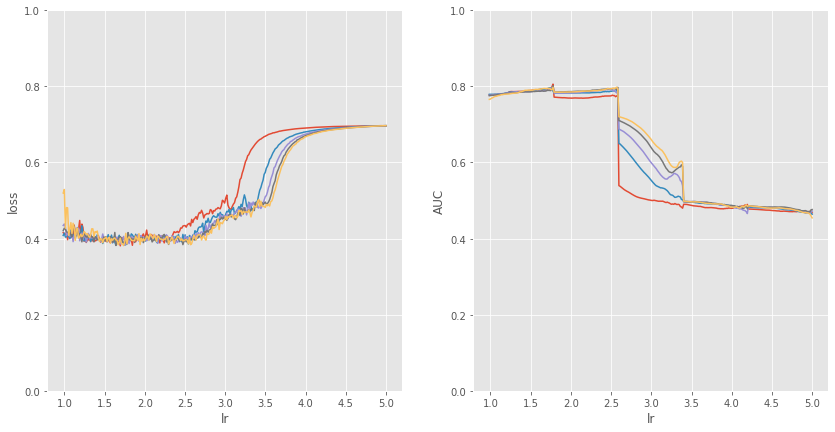

In [9]:
%matplotlib inline
mf.plot(True, [0, 1])

# fit one

In [12]:
%%time

batch_size = 8192
epochs = 100
nflod = 5

model_param = {'vocabulary_size':ecd.get_vocabulary(), 
               'feature_number': len(feature_col),
               'activation': 'sigmoid',
               'metrics': ['AUC'],
               'optimizer': 'Adam',
               'loss': 'binary_crossentropy',
               'use_linear': False,
               'use_deep': False}

clr = CyclicLR(base_lr=0.1**(4),
               max_lr = 0.1**(2.5), 
               step_size= int(4.0*(train_df.shape[0]*((nflod-1)/nflod)) / batch_size),
               mode='triangular2',
               gamma=1.0)

es = tf.keras.callbacks.EarlyStopping(monitor='val_AUC', patience=3, mode='max', restore_best_weights=True)

fit_param = {'batch_size': batch_size, 'epochs':epochs, 'verbose': 1, 'callbacks':[es, clr]}

model = auto_int(**model_param)

CPU times: user 267 ms, sys: 20.1 ms, total: 287 ms
Wall time: 282 ms


In [13]:
cv = CV(model, nflod)

score = cv.fit(x=[idx, val],
               y=y_train,
               metrics_func=roc_auc_score,
               split_method=StratifiedKFold,
               fit_params=fit_param,
               eval_param={'batch_size':batch_size},
               use_proba=False, 
               verbose=True,
               fit_use_valid=True)

tf.keras.backend.clear_session()

Train on 480000 samples, validate on 120000 samples
Epoch 1/100
480000/480000 [==============================] - 29s 61us/sample - loss: 0.6614 - AUC: 0.5025 - val_loss: 0.5482 - val_AUC: 0.4991
Epoch 2/100
480000/480000 [==============================] - 27s 55us/sample - loss: 0.4790 - AUC: 0.5855 - val_loss: 0.4552 - val_AUC: 0.7414
Epoch 3/100
480000/480000 [==============================] - 26s 55us/sample - loss: 0.4259 - AUC: 0.7632 - val_loss: 0.4015 - val_AUC: 0.7839
Epoch 4/100
480000/480000 [==============================] - 26s 55us/sample - loss: 0.3944 - AUC: 0.7919 - val_loss: 0.3968 - val_AUC: 0.7868
Epoch 5/100
480000/480000 [==============================] - 26s 55us/sample - loss: 0.3901 - AUC: 0.7969 - val_loss: 0.3973 - val_AUC: 0.7863
Epoch 6/100
480000/480000 [==============================] - 26s 55us/sample - loss: 0.3879 - AUC: 0.7996 - val_loss: 0.3978 - val_AUC: 0.7860
Epoch 7/100
480000/480000 [==============================] - 26s 55us/sample - loss: 0.386

# Tuning

In [ ]:
%matplotlib qt5

batch_size = 8192
epochs = 100
nflod = 5

# fit param

clr = CyclicLR(base_lr=0.1**(3.5),
               max_lr = 0.1**(2.5),
               step_size= int(4.0*(train_df.shape[0]*((nflod-1)/nflod)) / batch_size),
               mode='triangular2',
               gamma=1.0)

es = tf.keras.callbacks.EarlyStopping(monitor='val_AUC', 
                                      patience=3,
                                      mode='max',
                                      restore_best_weights=True)

fit_param = {
    'batch_size': batch_size, 
    'epochs':epochs, 
    'verbose': 0,
    'callbacks':[es, clr]
}

cv_fit_param = {'fit_params': fit_param, 
                'eval_param': {'batch_size':batch_size},
                'use_proba':False, 
                'fit_use_valid': True}

# model_fix_param & model_search_space
model_fix_param = {'vocabulary_size':ecd.get_vocabulary(), 
                   'feature_number': len(feature_col),
                   'activation': 'sigmoid',
                   'metrics': ['AUC'],
                   'optimizer': 'Adam', 
                   'use_linear': False, 
                   'use_deep': False}

ss = {
    'loss': (hp.choice, ('binary_crossentropy', 'focal_loss')), 
    'k': (hp.choice, (5, 7, 8, 10)),
    'num_cross': (hp.choice, (1, 2, 3 ,4)),
    'l2_em': (hp.loguniform, (-20, 0)),
    'l2_cross': (hp.loguniform, (-20, 0))}

# cv get score
def neg_auc(y_true, y_pred):
    return - roc_auc_score(y_true, y_pred)

gs = CVGetScore(x=[idx, val],
                y=y_train, 
                metrics_func=neg_auc,
                split_method=StratifiedKFold,
                nfolds=nflod, 
                random_state=2333,
                model=dcn, 
                cv_fit_params=cv_fit_param, 
                model_fix_params=model_fix_param, 
                model_search_space=ss)

tuning = Tuning(gs, verbose=1)
tuning.fmin(gs.GET_SEARCH_SPACE(), max_evals=100)

In [ ]:
log = tuning.log.get_log()

In [ ]:
log.sort_values('score').head(20)

In [ ]:
log.sort_values('score').tail(20)

In [ ]:
%matplotlib inline
tuning.log.plot(score_interval=[-0.789, -0.787])

In [ ]:
np.random.randint(2**32)

### 2072349059

In [ ]:
! mkdir ../tmp/cross

In [ ]:
log.to_csv('../tmp/cross/2072349059.csv', index=False)

In [ ]:
batch_size = 8192
epochs = 400
nflod = 40
nmodel = 5

In [ ]:
# model params
model_tuning_param = log.sort_values('score').head(nmodel).reset_index(drop=True).to_dict()

model_fix_param = {'vocabulary_size':ecd.get_vocabulary(), 
                   'feature_number': len(feature_col),
                   'activation': 'sigmoid',
                   'metrics': ['AUC'],
                   'optimizer': 'Adam', 
                   'use_linear': False, 
                   'use_deep': False}

In [ ]:
# callbacks
clr = CyclicLR(
    base_lr=1e-4,
    max_lr = 0.1**(2.5), 
    step_size= int(4.0*(train_df.shape[0]*((nflod-1)/nflod)) / batch_size),
    mode='triangular2',
    gamma=1.0)

es = tf.keras.callbacks.EarlyStopping(monitor='val_AUC', 
                                      patience=3,
                                      mode='max',
                                      restore_best_weights=True)

# fit
fit_param = {
    'batch_size': batch_size, 
    'epochs':epochs, 
    'verbose': 0,
    'callbacks':[es, clr]
}

# Stacking 1

In [ ]:
pred_lst = []
score_lst = []
pred_arr_lst = []

for i in range(nmodel):
    model_params = {}
    for param_name, param_value in model_fix_param.items():
        model_params[param_name] = param_value
        
    for param_name in model_tuning_param.keys():
        if param_name not in ['score', 'update', 'usetime', 'index']:
            model_params[param_name] = model_tuning_param[param_name][i]
            
    # cv
    model = dcn(**model_params)
    cv = CV(model, nflod)
    
    score, pred_arr = cv.fit(x=[idx, val],
                             y=y_train, 
                             metrics_func=roc_auc_score,
                             split_method=StratifiedKFold,
                             fit_params=fit_param,
                             eval_param={'batch_size':batch_size},
                             use_proba=False, 
                             verbose=True,
                             fit_use_valid=True,
                             output_oof_pred=True)
    
    pred = cv.predict(x=[idx_test, val_test], pred_param={'batch_size': batch_size})
    
    pred_lst.append(pred)
    score_lst.append(score)
    pred_arr_lst.append(pred_arr)
    
    print('score: ', score)
    tf.keras.backend.clear_session()

In [ ]:
pred_arr = np.array(pred_arr_lst).squeeze().T
np.save('../tmp/cross/2072349059stacking1.npy', pred_arr)
pred_arr.shape

In [ ]:
pred = np.array(pred_lst).squeeze().T
np.save('../tmp/cross/2072349059predict.npy', pred)
pred.shape

In [ ]:
submission = pd.read_csv('../data/sample_submission.csv', index_col='id')
submission['target'] = np.mean(pred_lst, axis=0)
submission.to_csv('../tmp/submission/main_5_crossnet_2072349059.csv')